Shortest path: ('route', inf)
All generated routes:
([0, 5, 10, 4, 8, 9, 11, 1, 6, 3, 2, 7, 0], inf)
([0, 4, 5, 7, 8, 3, 10, 9, 6, 11, 2, 1, 0], inf)
([0, 3, 9, 11, 8, 4, 6, 5, 10, 7, 2, 1, 0], inf)
([0, 4, 10, 5, 1, 6, 9, 8, 2, 7, 3, 11, 0], inf)
([0, 7, 4, 10, 2, 8, 9, 11, 6, 1, 3, 5, 0], inf)
([0, 3, 4, 5, 10, 7, 8, 9, 6, 1, 11, 2, 0], inf)
([0, 7, 3, 5, 11, 1, 6, 9, 8, 10, 4, 2, 0], inf)
([0, 5, 4, 10, 8, 9, 6, 1, 2, 11, 3, 7, 0], inf)
([0, 2, 4, 9, 10, 1, 6, 3, 5, 7, 8, 11, 0], inf)


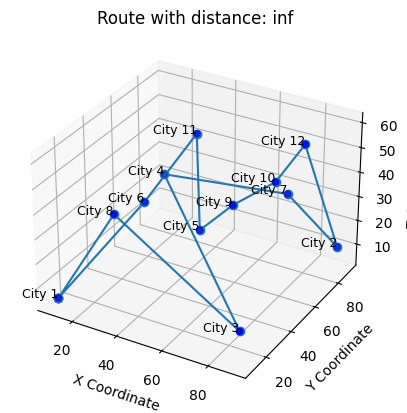

In [4]:
#ACO
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def euclidean_distance_3d(c1, c2):
    """Calculate the Euclidean distance between two points in 3D."""
    return np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2 + (c1[2] - c2[2])**2)

class AntColony:
    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        self.distances = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.all_routes = []  # Store all routes generated

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("route", float('inf'))
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.all_routes.extend(all_paths)  # Capture all routes
            self.spread_pheromone(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            self.pheromone *= self.decay
        return all_time_shortest_path

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = [start]
        visited = set([start])
        prev = start
        while len(visited) < len(self.distances):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append(move)
            prev = move
            visited.add(move)
        path.append(start)  # Return to the start to close the loop
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0
        row = pheromone ** self.alpha * ((1.0 / dist) ** self.beta)
        norm_row = row / row.sum()
        move = np.random.choice(self.all_inds, 1, p=norm_row)[0]
        return move

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in range(len(path) - 1):
            total_dist += self.distances[path[ele]][path[ele+1]]
        total_dist += self.distances[path[-1]][path[0]]  # Return to start
        return total_dist

    def spread_pheromone(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in range(len(path) - 1):
                self.pheromone[path[move]][path[move+1]] += 1.0 / self.distances[path[move]][path[move+1]]
            self.pheromone[path[-1]][path[0]] += 1.0 / self.distances[path[-1]][path[0]]

def plot_routes_3d(coordinates, routes):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for route, dist in routes:
        route_coords = coordinates[np.array(route)]
        route_coords = np.vstack([route_coords, route_coords[0]])  # Close the loop
        ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], color='blue', zorder=5)
        ax.plot(route_coords[:, 0], route_coords[:, 1], route_coords[:, 2], linestyle='-', marker='o')
        for i, coord in enumerate(coordinates):
            ax.text(coord[0], coord[1], coord[2], f'City {i+1}', fontsize=9, ha='right')
        ax.set_title(f'Route with distance: {dist:.2f}')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_zlabel('Z Coordinate')
        ax.grid(True)
        plt.show()

# Define the 3D coordinates
coordinates = np.array([
    [10, 10, 5],  # City 1
    [90, 90, 10],  # City 2
    [90, 10, 15],  # City 3
    [10, 90, 20],  # City 4
    [50, 50, 25],  # City 5
    [25, 50, 30],  # City 6
    [75, 75, 35],  # City 7
    [30, 20, 40],  # City 8
    [70, 40, 45],  # City 9
    [80, 55, 50],  # City 10
    [40, 65, 55],  # City 11
    [85, 69, 60]   # City 12
])
distances = np.array([[euclidean_distance_3d(coordinates[i], coordinates[j]) for j in range(len(coordinates))] for i in range(len(coordinates))])
np.fill_diagonal(distances, np.inf)

aco = AntColony(distances, n_ants=3, n_best=1, n_iterations=3, decay=0.95, alpha=1, beta=2)
result = aco.run()
print(f"Shortest path: {result}")

# Print and plot all generated routes
print("All generated routes:")
for path in aco.all_routes:
    print(path)
plot_routes_3d(coordinates, aco.all_routes)


Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.0005 seconds
Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.0004 seconds
Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.0004 seconds
Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.0010 seconds
Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.0004 seconds
Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.0004 seconds
Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.0004 seconds
Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.0004 seconds
Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.0004 seconds
Route: [0, 7, 5, 4, 10, 3, 6, 11, 1, 9, 8, 2, 0], Total distance: 447.12, Time taken: 0.000

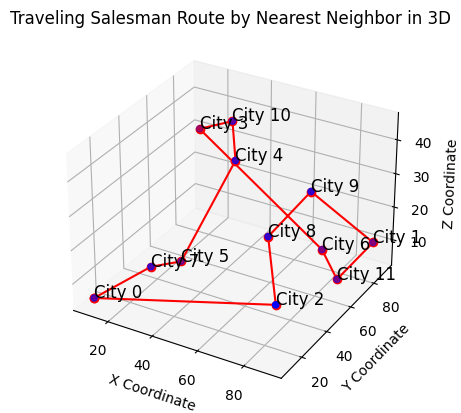

In [3]:
#NNO
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

def euclidean_distance_3d(c1, c2):
    """Calculate the Euclidean distance between two points in 3D."""
    return np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2 + (c1[2] - c2[2])**2)

def nearest_neighbor_3d(coordinates):
    """
    Solves the TSP using the nearest neighbor algorithm for 3D coordinates.
    :param coordinates: numpy array of shape (n, 3) where n is the number of cities
    :returns: Tuple (route, distance) where route is the list of visited cities in order
             and distance is the total length of the tour.
    """
    n = len(coordinates)
    visited = np.zeros(n, dtype=bool)
    route = []
    total_distance = 0
    current_city = 0
    route.append(current_city)
    visited[current_city] = True

    for _ in range(n - 1):
        nearest_city = None
        min_distance = np.inf
        for city in range(n):
            if not visited[city]:
                distance = euclidean_distance_3d(coordinates[current_city], coordinates[city])
                if distance < min_distance:
                    min_distance = distance
                    nearest_city = city
        visited[nearest_city] = True
        route.append(nearest_city)
        total_distance += min_distance
        current_city = nearest_city

    # Return to the starting city
    total_distance += euclidean_distance_3d(coordinates[route[-1]], coordinates[route[0]])
    route.append(route[0])  # close the loop

    return route, total_distance

def plot_route_3d(coordinates, route):
    """
    Plots the TSP route on a 3D plane.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    route_coords = coordinates[route]
    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], color='blue', zorder=5)
    ax.plot(route_coords[:, 0], route_coords[:, 1], route_coords[:, 2], color='red', linestyle='-', marker='o')
    for i, coord in enumerate(coordinates):
        ax.text(coord[0], coord[1], coord[2], f'City {i}', fontsize=12)
    ax.set_title('Traveling Salesman Route by Nearest Neighbor in 3D')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.grid(True)
    plt.show()

# Updated coordinates with 12 cities in 3D
coordinates = np.array([
    [10, 10, 5], [90, 90, 10], [90, 10, 20], [10, 90, 30],
    [50, 50, 40], [25, 50, 5], [75, 75, 10], [30, 20, 15],
    [70, 40, 25], [80, 55, 35], [40, 65, 45], [85, 69, 5]
])

results = []
num_runs = 10  # Number of runs for consistency testing

for _ in range(num_runs):
    start_time = time.time()
    route, distance = nearest_neighbor_3d(coordinates)
    end_time = time.time()
    results.append((route, distance, end_time - start_time))

for result in results:
    print(f"Route: {result[0]}, Total distance: {result[1]:.2f}, Time taken: {result[2]:.4f} seconds")

# Plot the route from the last run
plot_route_3d(coordinates, results[-1][0])


Generation 0: Best distance = 587.49


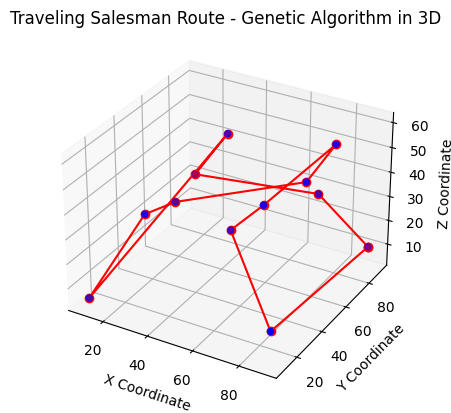

Generation 20: Best distance = 501.21


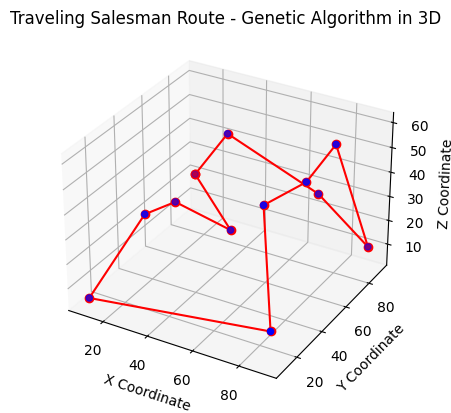

Generation 40: Best distance = 501.21


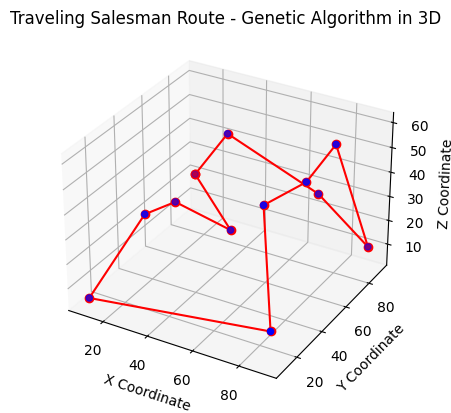

Generation 60: Best distance = 501.21


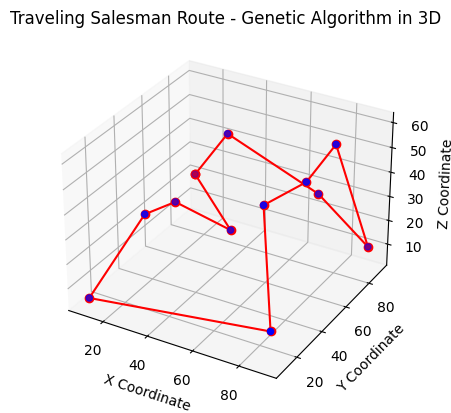

Generation 80: Best distance = 501.21


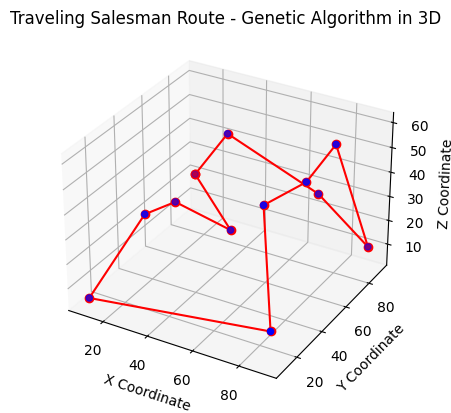

Generation 100: Best distance = 501.21


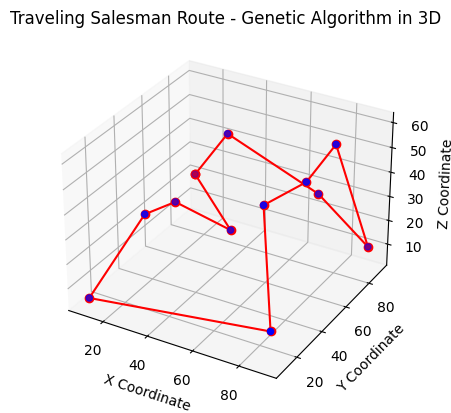

Generation 120: Best distance = 495.33


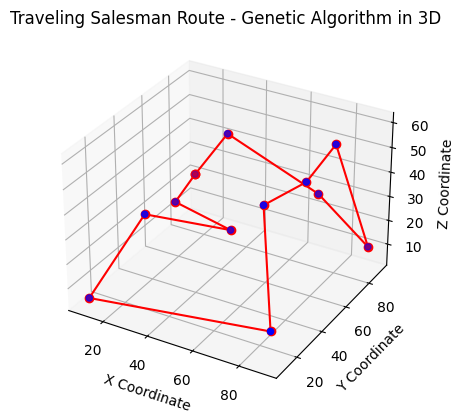

Generation 140: Best distance = 495.33


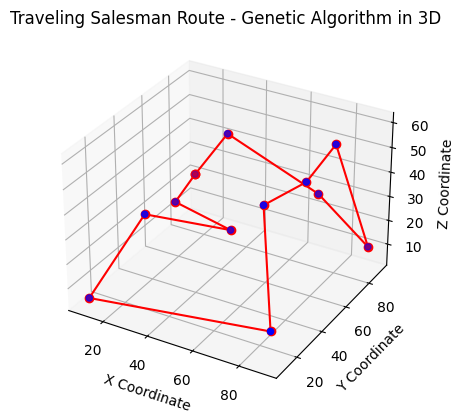

Generation 160: Best distance = 495.33


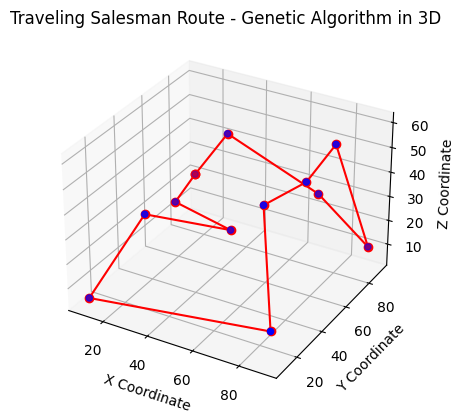

Generation 180: Best distance = 495.33


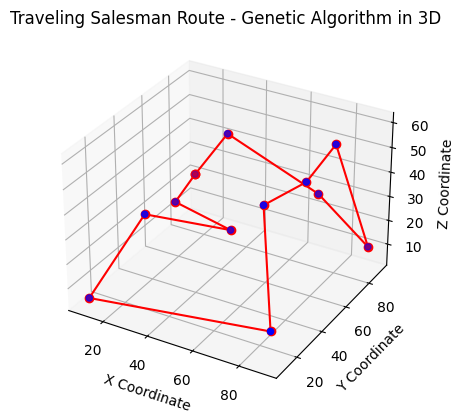

Final Best route: [3, 10, 6, 1, 11, 9, 8, 2, 0, 7, 4, 5]
Final Best distance: 495.33
Elapsed time: 2.63 seconds


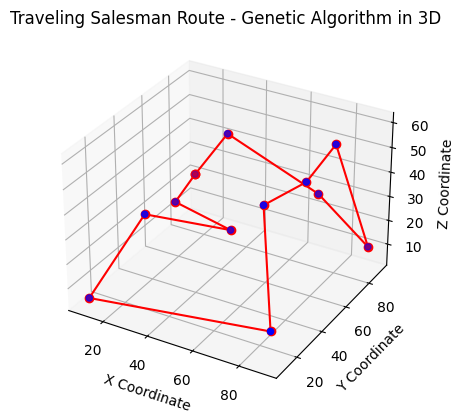

In [5]:
#G_TSP

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import time

def euclidean_distance_3d(c1, c2):
    """Calculate the Euclidean distance between two points in 3D."""
    return np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2 + (c1[2] - c2[2])**2)

def create_distance_matrix(coordinates):
    n = len(coordinates)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = euclidean_distance_3d(coordinates[i], coordinates[j])
            else:
                distance_matrix[i][j] = np.inf
    return distance_matrix

def initialize_population(size, num_cities):
    return [random.sample(range(num_cities), num_cities) for _ in range(size)]

def calculate_fitness(population, distance_matrix):
    fitness = np.zeros(len(population))
    for i, individual in enumerate(population):
        route_distance = sum(distance_matrix[individual[j], individual[j + 1]] for j in range(len(individual) - 1))
        route_distance += distance_matrix[individual[-1], individual[0]]
        fitness[i] = 1 / route_distance
    return fitness

def select_parents(population, fitness, num_parents):
    parents = []
    for _ in range(num_parents):
        parents.append(population[np.argmax(fitness)])
        fitness[np.argmax(fitness)] = 0  # Set fitness to zero to prevent reselection
    return parents

def crossover(parents, offspring_size):
    offspring = []
    for _ in range(offspring_size):
        parent1, parent2 = random.sample(parents, 2)
        crossover_point = random.randint(0, len(parent1) - 1)
        child = parent1[:crossover_point] + [city for city in parent2 if city not in parent1[:crossover_point]]
        offspring.append(child)
    return offspring

def mutate(offspring, mutation_rate):
    for i in range(len(offspring)):
        if random.random() < mutation_rate:
            swap_indices = random.sample(range(len(offspring[i])), 2)
            offspring[i][swap_indices[0]], offspring[i][swap_indices[1]] = offspring[i][swap_indices[1]], offspring[i][swap_indices[0]]
    return offspring

def genetic_algorithm(coordinates, population_size, num_generations, mutation_rate):
    num_cities = len(coordinates)
    distance_matrix = create_distance_matrix(coordinates)
    population = initialize_population(population_size, num_cities)
    best_distance = np.inf
    best_route = None

    for generation in range(num_generations):
        fitness = calculate_fitness(population, distance_matrix)
        best_idx = np.argmax(fitness)
        current_best_dist = 1 / fitness[best_idx]
        if current_best_dist < best_distance:
            best_distance = current_best_dist
            best_route = population[best_idx]
        if generation % 20 == 0:  # Print and plot every 20 generations
            print(f"Generation {generation}: Best distance = {current_best_dist:.2f}")
            plot_route_3d(coordinates, population[best_idx])

        parents = select_parents(population, fitness, population_size // 2)
        offspring = crossover(parents, offspring_size=len(population) - len(parents))
        offspring = mutate(offspring, mutation_rate)
        population = parents + offspring

    return best_route, best_distance

def plot_route_3d(coordinates, route):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    route_coords = coordinates[route + [route[0]]]
    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], color='blue')
    ax.plot(route_coords[:, 0], route_coords[:, 1], route_coords[:, 2], color='red', marker='o')
    ax.set_title('Traveling Salesman Route - Genetic Algorithm in 3D')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.grid(True)
    plt.show()

# Parameters and run GA
coordinates = np.array([
    [10, 10, 5], [90, 90, 10], [90, 10, 15], [10, 90, 20],
    [50, 50, 25], [25, 50, 30], [75, 75, 35], [30, 20, 40],
    [70, 40, 45], [80, 55, 50], [40, 65, 55], [85, 69, 60]
])
population_size = 100
num_generations = 200
mutation_rate = 0.01

start_time = time.time()
best_route, best_distance = genetic_algorithm(coordinates, population_size, num_generations, mutation_rate)
end_time = time.time()

print(f"Final Best route: {best_route}")
print(f"Final Best distance: {best_distance:.2f}")
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

# Final plot of the best route found
plot_route_3d(coordinates, best_route)


Optimal Path: ('City 0', 'City 2', 'City 1', 'City 4', 'City 3', 'City 5')
Minimum Distance: 369.46 units
Computation Time: 0.0062 seconds


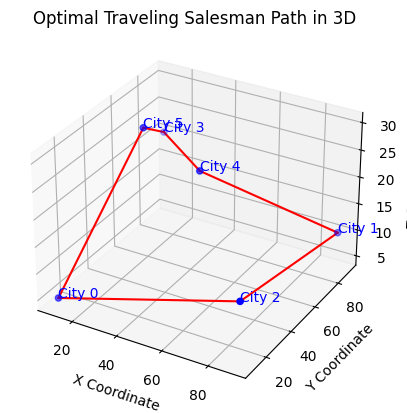

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import time

def euclidean_distance_3d(c1, c2):
    """Calculate the Euclidean distance between two points in 3D."""
    return np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2 + (c1[2] - c2[2])**2)

def create_graph(coordinates):
    """Initialize the graph with given city coordinates and distances in 3D."""
    G = nx.Graph()
    num_cities = len(coordinates)
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            distance = euclidean_distance_3d(coordinates[i], coordinates[j])
            G.add_edge(f'City {i}', f'City {j}', weight=distance)
    return G

def calculate_path_cost(G, path):
    """Calculate total distance of the given path in the graph."""
    total_distance = 0
    for i in range(len(path) - 1):
        total_distance += G[path[i]][path[i + 1]]['weight']
    total_distance += G[path[-1]][path[0]]['weight']  # Return to the start
    return total_distance

def find_optimal_path(G, nodes):
    """Find the path with the minimum distance using a brute-force approach."""
    min_distance = float('inf')
    optimal_path = None
    for path in itertools.permutations(nodes):
        distance = calculate_path_cost(G, path)
        if distance < min_distance:
            min_distance = distance
            optimal_path = path
    return optimal_path, min_distance

def plot_3d_route(G, coordinates, path):
    """Plot the graph and path in 3D."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Convert path from city labels to indices
    path_indices = [int(node.split(' ')[1]) for node in path]

    # Plotting the cities
    for i, (x, y, z) in enumerate(coordinates):
        ax.text(x, y, z, f'City {i}', color='blue', fontsize=10)
    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c='blue', depthshade=True)

    # Plotting the path
    path_edges = list(zip(path_indices, path_indices[1:] + [path_indices[0]]))
    for u, v in path_edges:
        x = [coordinates[u][0], coordinates[v][0]]
        y = [coordinates[u][1], coordinates[v][1]]
        z = [coordinates[u][2], coordinates[v][2]]
        ax.plot(x, y, z, color='red')

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    plt.title('Optimal Traveling Salesman Path in 3D')
    plt.show()


def main():
    # Define coordinates for 6 cities in 3D space
    coordinates = np.array([
        (10, 10, 5), (90, 90, 10), (90, 10, 15), (10, 90, 20),
        (50, 50, 25), (25, 50, 30)
    ])
    nodes = [f'City {i}' for i in range(len(coordinates))]
    G = create_graph(coordinates)
    start_time = time.time()
    optimal_path, min_distance = find_optimal_path(G, nodes)
    elapsed_time = time.time() - start_time

    print(f"Optimal Path: {optimal_path}")
    print(f"Minimum Distance: {min_distance:.2f} units")
    print(f"Computation Time: {elapsed_time:.4f} seconds")

    # Plotting the graph with optimal path highlighted in 3D
    plot_3d_route(G, coordinates, optimal_path)

if __name__ == "__main__":
    main()
